# CNN con Pytorch

Repetimos el ejemplo de Keras pero ahora utilizando Pytorch. Como veremos es mucho mas complejo ya que nos permite definir mas en detalle todo el proceso.

In [1]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Definimos la arquitectura de la CNN

Definimos como el modelo debe cargar los datos

In [2]:
class MyDataset(Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = F.one_hot(torch.tensor(self.dataset[idx]["label"]), num_classes=20).float()

        image = self.transforms(image)
        return image, label

Definimos el proceso de entrenamiento paso a paso

In [3]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

Definimos el proceso de validacion paso a paso

In [4]:
def validation(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target).sum().item()

    val_loss /= len(val_loader.dataset)
    print(f'\nTest set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')

Cargamos los datos igual que hicimos antes

In [5]:
!pip install datasets --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
from datasets import load_dataset

ds = load_dataset("Sonam02/Fruit", split="train")
ds = ds.train_test_split(test_size=0.2, shuffle=True, stratify_by_column='label')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fruits.zip:   0%|          | 0.00/178k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5
    })
})

In [7]:
fila_ejemplo = ds['train'][0]
fila_ejemplo

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168>,
 'label': 1}

(168, 300, 3)


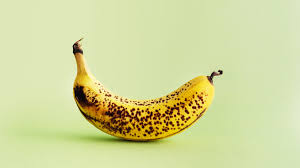

In [8]:
print(np.array(fila_ejemplo['image']).shape)
fila_ejemplo['image']

In [9]:
fila_ejemplo['label']

1

In [10]:
labels = ds['train'].features['label']
len(labels.names), labels.names

(2, ['apple', 'banana'])

In [11]:
len(ds['train'])

18

In [12]:
my_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset = MyDataset(ds['train'], my_transforms)
val_dataset = MyDataset(ds['test'], my_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [14]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [15]:
train_dataset[0][1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [18]:
# instalar pillow
!pip install pillow --quiet

In [16]:
import torchvision.models as models
model = models.mobilenet_v2() # entrena desde cero
#model = models.mobilenet_v2(pretrained=True) # hace finetuning
model.classifier[1] = nn.Linear(model.last_channel, 20)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(1, 10):
    train(model, device, train_loader, criterion, optimizer, epoch)
    validation(model, device, val_loader, criterion)

#torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/18 (0%)]	Loss: 3.164459

Test set: Average loss: 0.5847, Accuracy: 3/5 (60%)

Train Epoch: 2 [0/18 (0%)]	Loss: 2.066502

Test set: Average loss: 0.5468, Accuracy: 3/5 (60%)

Train Epoch: 3 [0/18 (0%)]	Loss: 1.054333

Test set: Average loss: 0.4876, Accuracy: 3/5 (60%)

Train Epoch: 4 [0/18 (0%)]	Loss: 0.385351

Test set: Average loss: 0.4176, Accuracy: 3/5 (60%)

Train Epoch: 5 [0/18 (0%)]	Loss: 0.106190

Test set: Average loss: 0.3602, Accuracy: 3/5 (60%)

Train Epoch: 6 [0/18 (0%)]	Loss: 0.036258

Test set: Average loss: 0.3377, Accuracy: 3/5 (60%)

Train Epoch: 7 [0/18 (0%)]	Loss: 0.125802

Test set: Average loss: 0.3488, Accuracy: 3/5 (60%)

Train Epoch: 8 [0/18 (0%)]	Loss: 0.015006

Test set: Average loss: 0.3775, Accuracy: 3/5 (60%)

Train Epoch: 9 [0/18 (0%)]	Loss: 0.016879

Test set: Average loss: 0.4086, Accuracy: 3/5 (60%)



## Predecir una imagen nueva

In [20]:
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms

def predict_image(model, image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        predicted_class = output.argmax(dim=1).item()

    return predicted_class

image_path = 'https://www.collinsdictionary.com/images/full/banana_64728013.jpg'
predicted_class = predict_image(model, image_path)
print(f"The predicted class for the image is: {predicted_class}")


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7b78d968dd50>

## Como guardar el modelo entrenado en hugging face

In [ ]:
from huggingface_hub import HfApi
from huggingface_hub import notebook_login

notebook_login()

# cambiar el nombre de usuario
nombre_del_modelo = "amiune/snack-classifier-pytorch"

api = HfApi()
api.create_repo(repo_id=nombre_del_modelo, exist_ok=True)


model_path = "snack-classifier"
os.makedirs(model_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))

api.upload_folder(
    folder_path=model_path,
    path_in_repo="",
    repo_id=nombre_del_modelo,
)


# Fin: [Volver al contenido del curso](https://www.freecodingtour.com/cursos/espanol/deeplearning/deeplearning.html)

## Referencias:

- https://github.com/pytorch/examples/blob/main/mnist/main.py
- https://www.kaggle.com/datasets/oddrationale/mnist-in-csv